# Aligning single-cell resolution breast cancer spatial transcriptomics data to corresponding H&E staining image from Xenium

In this notebook, we take a single cell resolution spatial transcriptomics datasets of a breast cancer section profiled by the Xenium technology and align it to a corresponding H&E staining image of the same tissue section. See the bioRxiv preprint for more details about this data: https://www.biorxiv.org/content/10.1101/2022.10.06.510405v2 

According to the authors, "Due to the non-destructive nature of the Xenium workflow, we were able to perform H&E staining...on the same section post-processing." However, as the H&E staining and imaging was done seprately to the spatial transcriptomics data collection, alignment is still needed to register the H&E staining image with the single cell positions from the spatial transcriptomics data. 

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [5]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# import STalign from upper directory
# skip next 2 lines if STalign.py in same folder as notebook
import sys
sys.path.append("..") 
import STalign

from STalign import STalign

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

To obtain the single cell spatial transcriptomics data, we can download the `Xenium Output Bundle` from the 10X website: https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast Expanding the downloaded `Xenium_FFPE_Human_Breast_Cancer_Rep1_outs.zip`, we will use the single cell positions stored in `cells.csv.gz`. Likewise, we can download the accompanying H&E staining image `Supplemental: Post-Xenium H&E image (TIFF)` as `Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.tif`. 

To reproduce this tutorial, we have placed these files in a folder called [`xenium_data/`](https://github.com/JEFworks-Lab/STalign/tree/main/docs/xenium_data) with `cells.csv.gz` renamed as `Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz` for organizational purposes. Likewise, to minimize storage, we have resized the high resolution H&E TIF image into a smaller PNG image as `Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.png`

We can read in the H&E staining image using `matplotlib.pyplot` as `plt`. 

In [6]:
# Target is H&E staining image
image_file = '../xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.png'
V = plt.imread(image_file)

# plot
fig,ax = plt.subplots()
ax.imshow(V)

Note that this is an RGB image that `matplotlib.pyplot` had read in as an NxMx3 matrix with values ranging from 0 to 1.

In [7]:
print(V.shape)
print(V.min())
print(V.max())

(2051, 2759, 3)
0.0
1.0


We will use `STalign` to normalize the image in case there are any outlier intensities. 

In [8]:
Inorm = STalign.normalize(V)

print(Inorm.min())
print(Inorm.max())

fig,ax = plt.subplots()
ax.imshow(Inorm)

0.0
1.0


We will transpose `Inorm` to be a 3xNxM matrix for downstream analyses. We will also create some variances `YI` and `XI` to keep track of the image size.

In [9]:
I = Inorm.transpose(2,0,1)
print(I.shape)

YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
extentI = STalign.extent_from_x((YI,XI))

(3, 2051, 2759)


We can also now read in the corresponding single cell information using `pandas` as `pd`.

In [10]:
# Single cell data to be aligned
fname = '../xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz'
df = pd.read_csv(fname)
df.head()

cell_id  x_centroid  y_centroid  transcript_counts  control_probe_counts   
0        1  377.663005  843.541888                154                     0  \
1        2  382.078658  858.944818                 64                     0   
2        3  319.839529  869.196542                 57                     0   
3        4  259.304707  851.797949                120                     0   
4        5  370.576291  865.193024                120                     0   

   control_codeword_counts  total_counts   cell_area  nucleus_area  
0                        0           154  110.361875     45.562656  
1                        0            64   87.919219     24.248906  
2                        0            57   52.561875     23.526406  
3                        0           120   75.230312     35.176719  
4                        0           120  180.218594     34.499375

For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

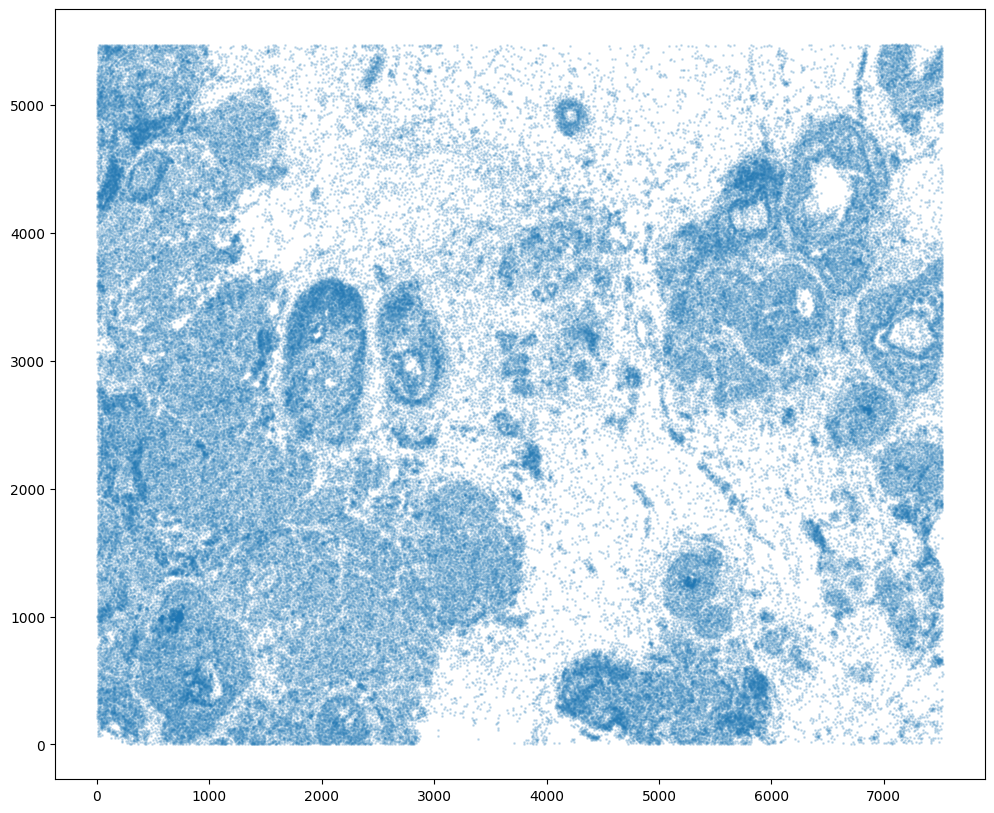

In [11]:
# get cell centroid coordinates
xM = np.array(df['x_centroid'])
yM = np.array(df['y_centroid'])

# plot
fig,ax = plt.subplots()
ax.scatter(xM,yM,s=1,alpha=0.2)

Note that plotting the cell centroid positions on the corresponding H&E image shows that alignment is still needed.

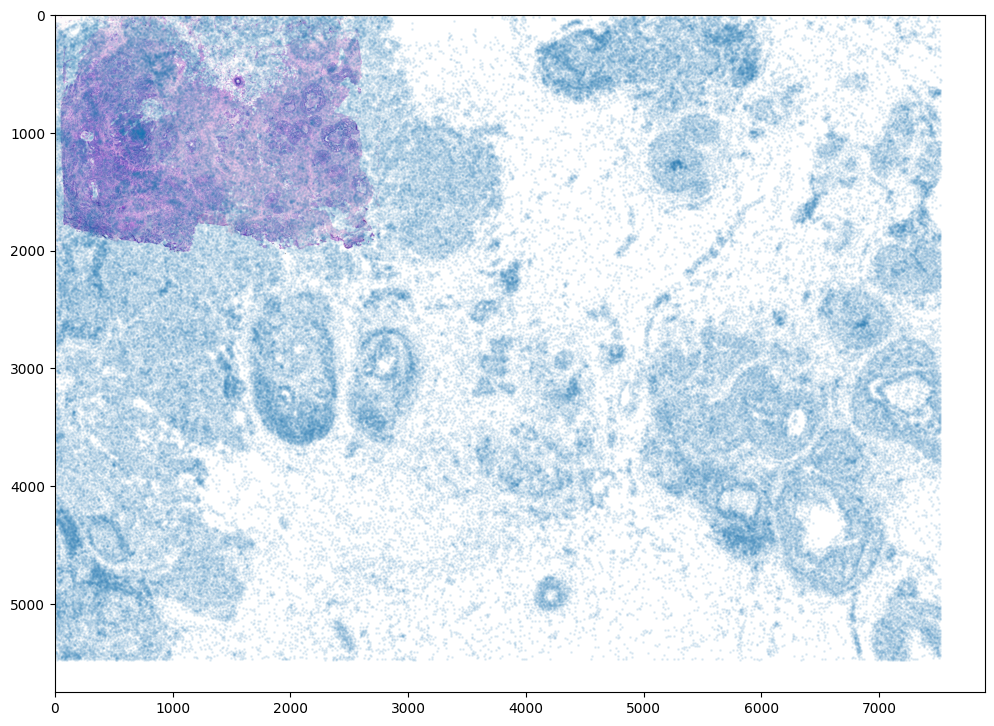

In [12]:
# plot
fig,ax = plt.subplots()
ax.imshow((I).transpose(1,2,0),extent=extentI)
ax.scatter(xM,yM,s=1,alpha=0.1)

To begin our alignment, we will use STalign to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency.

0 of 167782
10000 of 167782
20000 of 167782
30000 of 167782
40000 of 167782
50000 of 167782
60000 of 167782
70000 of 167782
80000 of 167782
90000 of 167782
100000 of 167782
110000 of 167782
120000 of 167782
130000 of 167782
140000 of 167782
150000 of 167782
160000 of 167782
167781 of 167782


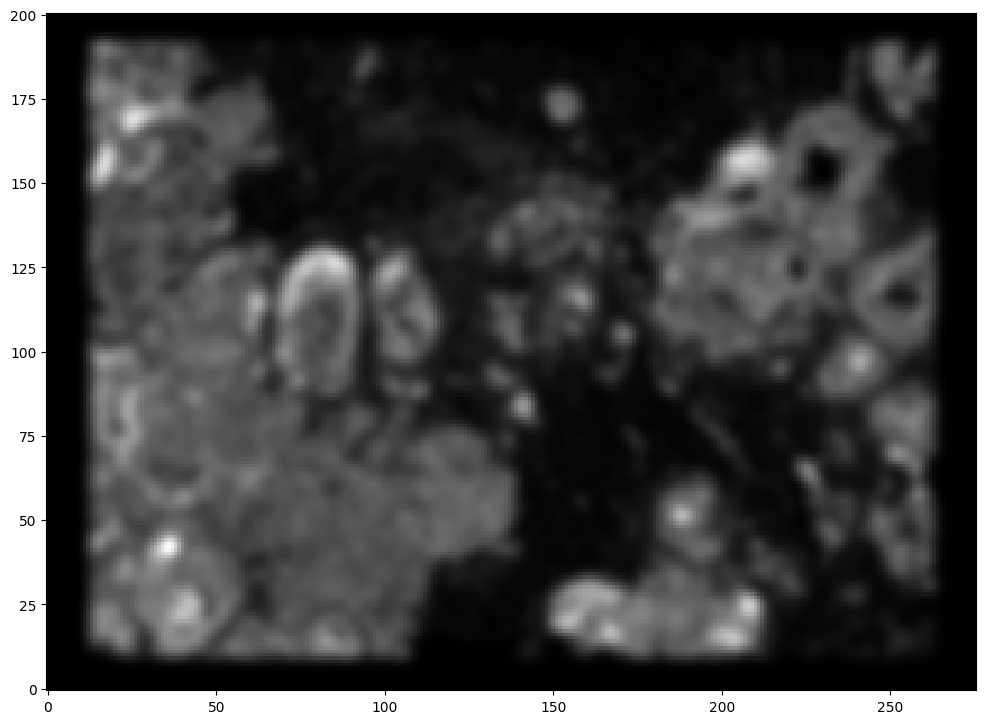

In [13]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XJ,YJ,M,fig = STalign.rasterize(xM, yM, dx=30)

ax = fig.axes[0]
ax.invert_yaxis()

Note that this is a 1D greyscale image. To align with an RGB H&E image, we will need to make our greyscale image into RGB by simply stacking the 1D values 3 times. We will also normalize to get intensity values between 0 to 1. We now have an H&E image and a rasterized image corresponding to the single cell positions from the spatial transcriptomics data that we can align.

In [14]:
print(M.shape)
J = np.vstack((M, M, M)) # make into 3xNxM
print(J.min())
print(J.max())

# normalize
J = STalign.normalize(J)
print(J.min())
print(J.max())

# double check size of things
print(I.shape)
print(M.shape)
print(J.shape)

(1, 201, 276)
0.0
16.134067631252954
0.0
1.0
(3, 2051, 2759)
(1, 201, 276)
(3, 201, 276)


`STalign` relies on an interative gradient descent to align these two images. This can be somewhat slow. We manually created 3 points that visually mark similar landmarks across the two datasets that we will use to initialize a simple affine alignment from the landmark points. 

We can double check that our landmark points look sensible by plotting them along with the rasterized image we created.

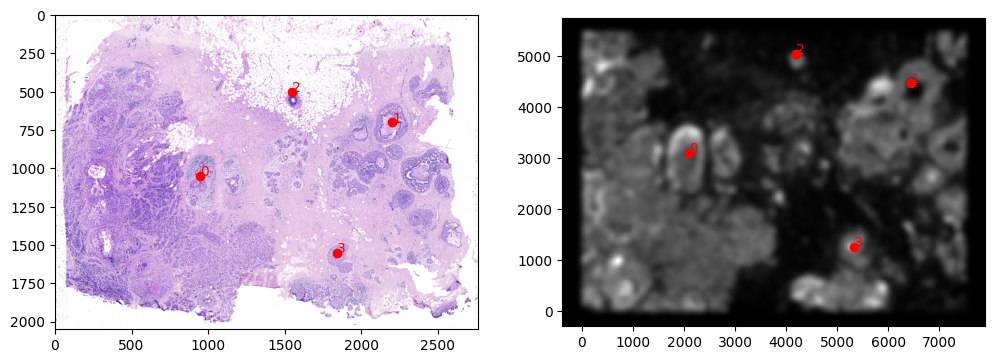

In [15]:
# manually make corresponding points
pointsI = np.array([[1050.,950.], [700., 2200.], [500., 1550.], [1550., 1840.]])
pointsJ = np.array([[3108.,2100.], [4480., 6440.], [5040., 4200.], [1260., 5320.]]) 

# plot
extentJ = STalign.extent_from_x((YJ,XJ))

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red')
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red')
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}', c='red')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}', c='red')

# invert only rasterized image
ax[1].invert_yaxis()

In [16]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsI,pointsJ)

From this simple affine transformation based on landmark points, we can already apply the resulting lineared linear transformation (L) and translation (T) to align the single-cell spatial transcriptomics dataset to the H&E staining image. Note that the derived affine transformation is the transformation and translation needed to align the H&E staining image to the single-cell positions. To align the single-cell positions, we will need to invert the linear transformation matrix using `linalg.inv` and shift in the negative direction by subtracting instead of adding. 

[[-3.65041156  0.06574554]
 [ 0.11365427  3.50866925]]
[ 6832.39702429 -1329.64577839]
(2, 2)
(2,)
(2, 167782)


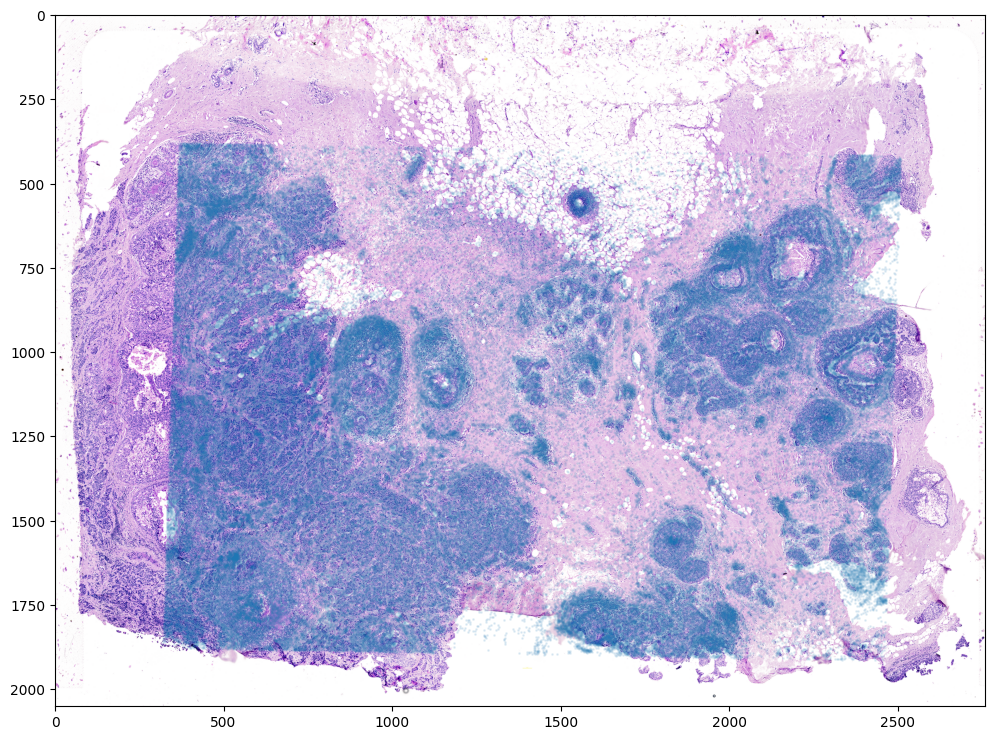

In [17]:
print(L)
print(T)
print(L.shape)
print(T.shape)

# note points are as y,x
affine = np.dot(np.linalg.inv(L), [yM - T[0], xM - T[1]]) 
print(affine.shape)
xMaffine = affine[0,:] 
yMaffine = affine[1,:] 

# plot
fig,ax = plt.subplots()
ax.scatter(yMaffine,xMaffine,s=1,alpha=0.1)
ax.imshow((I).transpose(1,2,0))

In this case, it seems like either due to the accuracy of our landmark points and/or distortions in the tissue sample introduced during the H&E staining, a simple affine alignment is not sufficient to align the single-cell spatial transcriptomics dataset to the H&E staining image. So we will need to perform non-linear local alignments via LDDMM. 

There are many parameters that can be tuned for performing this alignment. 

CPU times: user 3min 22s, sys: 24.2 s, total: 3min 47s
Wall time: 3min 16s


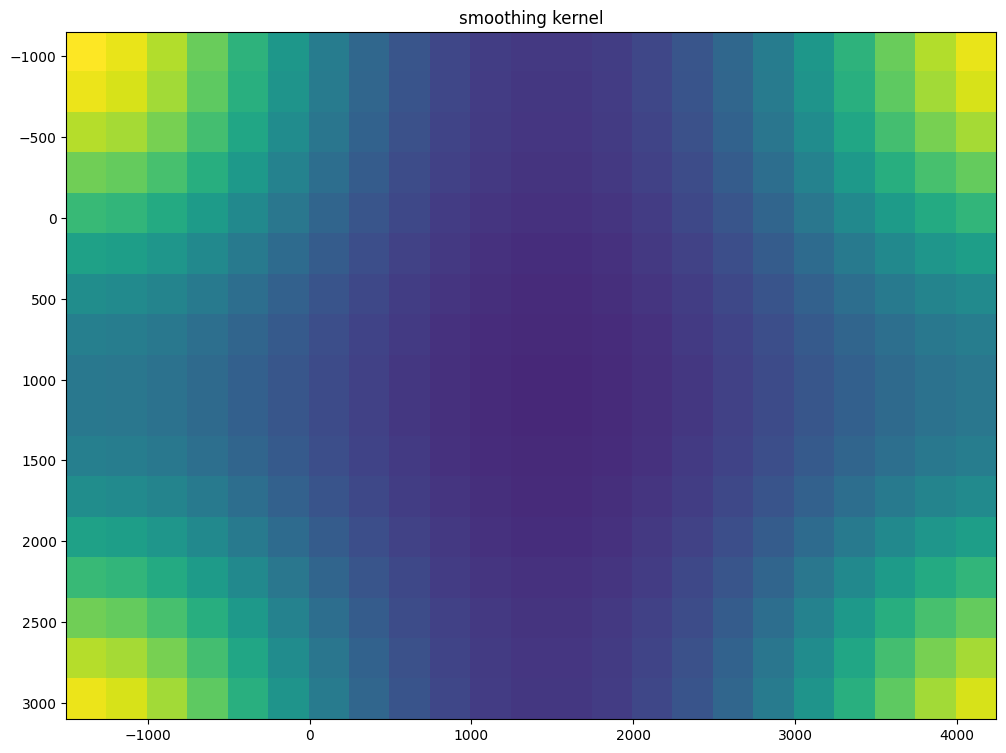

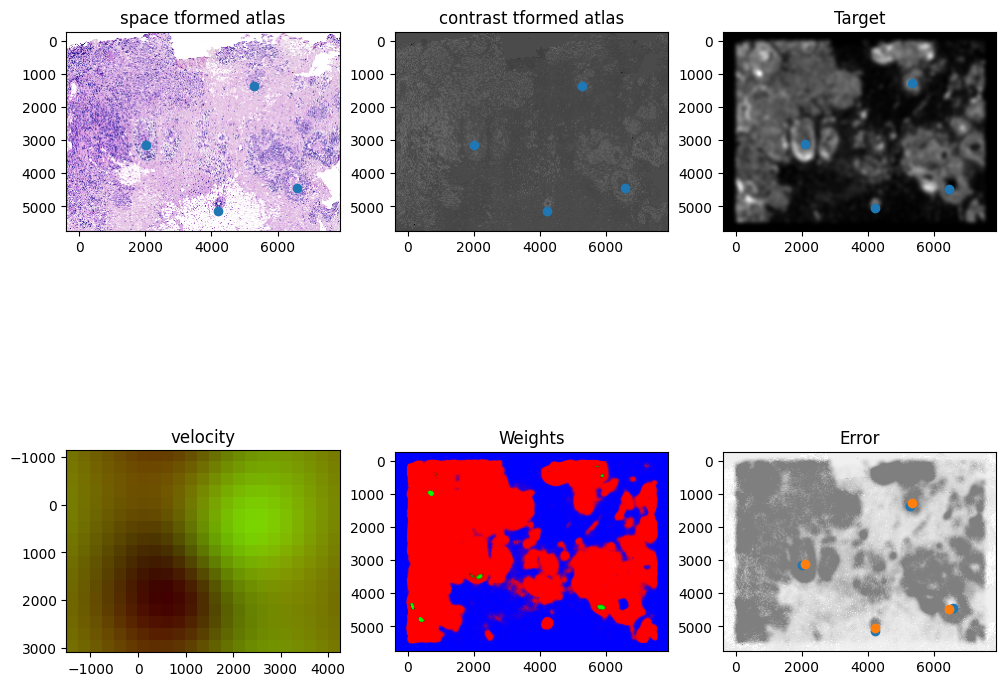

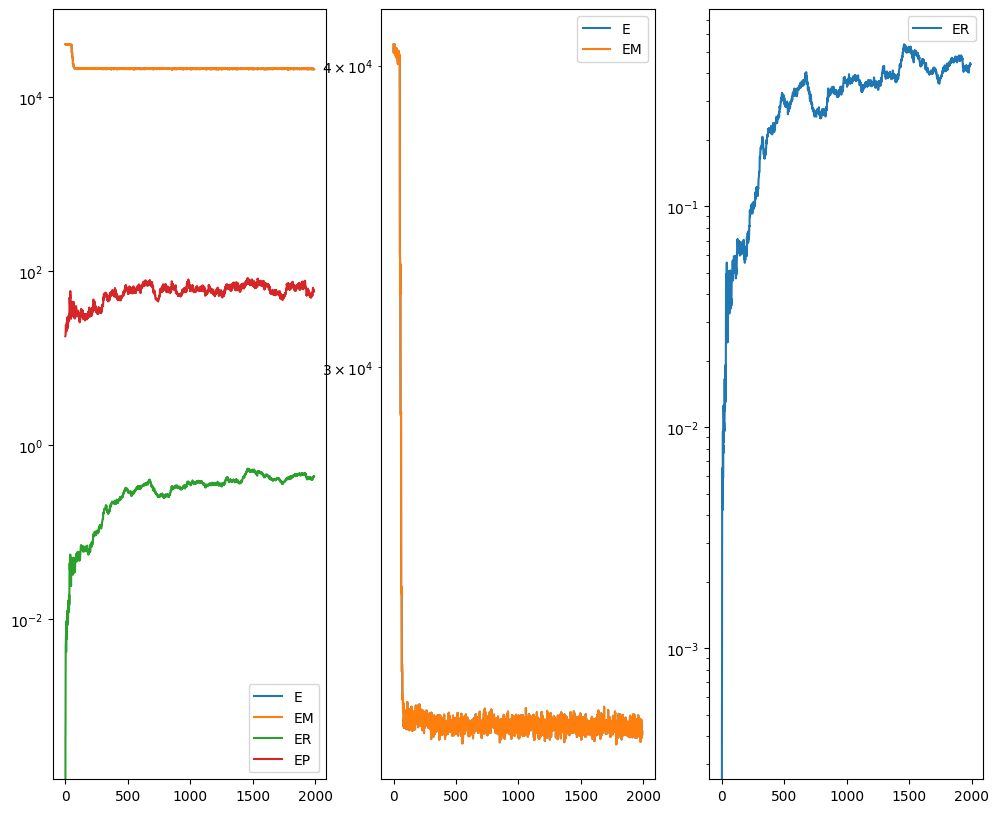

In [19]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {'L':L,'T':T,
          'niter':2000,
          'pointsI':pointsI,
          'pointsJ':pointsJ,
          'device':device,
          'sigmaM':0.15, 
          'sigmaB':0.10,
          'sigmaA':0.11,
          'epV': 10,
          'muB': torch.tensor([0,0,0]), # black is background in target
          'muA': torch.tensor([1,1,1]) # use white as artifact 
          }

out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

In [20]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

/Users/gohtaaihara/.local/share/virtualenvs/STalign-oDkYRjeO/lib/python3.11/site-packages/STalign/STalign.py:1660: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
/Users/gohtaaihara/.local/share/virtualenvs/STalign-oDkYRjeO/lib/python3.11/site-packages/STalign/STalign.py:1661: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if v is not None: v = torch.tensor(v)
/Users/gohtaaihara/.local/share/virtualenvs/STalign-oDkYRjeO/lib/python3.11/site-packages/STalign/STalign.py:1673: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ 

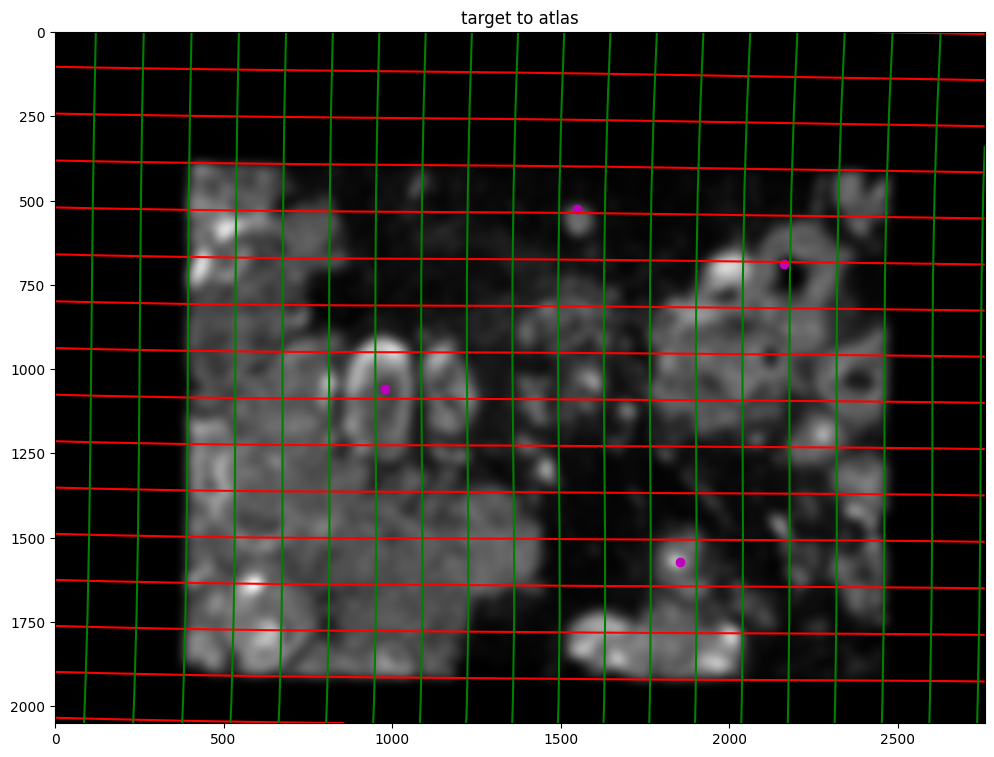

In [21]:
# now transform the points 
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],J,[YI,XI])
phiipointsJ = STalign.transform_points_target_to_atlas(xv,v,A,pointsJ)

# plot
fig,ax = plt.subplots()

levels = np.arange(-50000,50000,500)

ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to atlas')

ax.imshow(phiiJ.permute(1,2,0),extent=extentI)
ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="m")

Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [22]:
# Now apply to points 
tpointsI = STalign.transform_points_target_to_atlas(xv,v,A,np.stack([yM, xM], -1))
phiipointsJ = STalign.transform_points_target_to_atlas(xv,v,A,pointsJ)

And we can visualize the results.

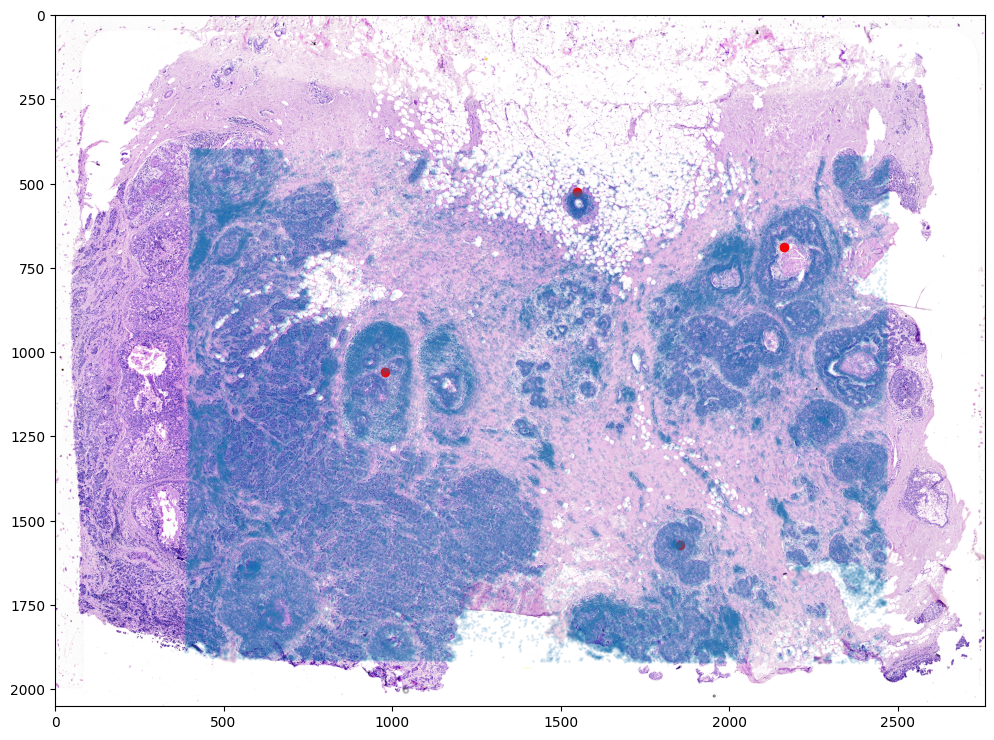

In [23]:
# plot
fig,ax = plt.subplots()
ax.imshow((I).transpose(1,2,0),extent=extentI)
ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="r")
ax.scatter(tpointsI[:,1].detach(),tpointsI[:,0].detach(),s=1,alpha=0.1)

And save the new aligned positions by appending to our original data using `numpy` with `np.hstack` and save the output as a new csv file with `np.savetxt`.

In [24]:
# save results by appending
results = np.hstack((df, tpointsI.numpy()))
np.savetxt('../xenium_data/Xenium_Breast_Cancer_Rep1_STalign_to_HE.csv', results, delimiter=',')

We will finally `gzip` to compress the `.csv` file to create `Xenium_Breast_Cancer_Rep1_STalign_to_HE.csv.gz`